In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 10,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_10_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1t2_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 920)
(734160, 1)
validation
(101248, 920)
(101248, 1)
test
(100432, 920)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 920)]             0         


 dense (Dense)               (None, 1024)              943104    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1632257 (6.23 MB)


Trainable params: 1632257 (6.23 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 12:37 - loss: 0.1654 - STD: 1.3814e-04 - MAE: 0.3952

 15/735 [..............................] - ETA: 2s - loss: 0.0348 - STD: 1.2575e-04 - MAE: 0.1474   

 30/735 [>.............................] - ETA: 2s - loss: 0.0243 - STD: 8.3497e-05 - MAE: 0.1194

 45/735 [>.............................] - ETA: 2s - loss: 0.0194 - STD: 6.0933e-05 - MAE: 0.1051

 61/735 [=>............................] - ETA: 2s - loss: 0.0168 - STD: 4.9363e-05 - MAE: 0.0976

 64/735 [=>............................] - ETA: 6s - loss: 0.0165 - STD: 4.7992e-05 - MAE: 0.0965

 79/735 [==>...........................] - ETA: 5s - loss: 0.0151 - STD: 4.3480e-05 - MAE: 0.0923

 95/735 [==>...........................] - ETA: 5s - loss: 0.0141 - STD: 4.1520e-05 - MAE: 0.0893

111/735 [===>..........................] - ETA: 4s - loss: 0.0134 - STD: 4.1792e-05 - MAE: 0.0874

126/735 [====>.........................] - ETA: 4s - loss: 0.0129 - STD: 4.3768e-05 - MAE: 0.0859

142/735 [====>.........................] - ETA: 3s - loss: 0.0124 - STD: 4.7758e-05 - MAE: 0.0847

157/735 [=====>........................] - ETA: 3s - loss: 0.0121 - STD: 5.3596e-05 - MAE: 0.0839

172/735 [======>.......................] - ETA: 3s - loss: 0.0119 - STD: 6.2236e-05 - MAE: 0.0831

188/735 [======>.......................] - ETA: 3s - loss: 0.0117 - STD: 7.5955e-05 - MAE: 0.0825

204/735 [=======>......................] - ETA: 2s - loss: 0.0115 - STD: 9.8190e-05 - MAE: 0.0819

221/735 [========>.....................] - ETA: 2s - loss: 0.0113 - STD: 1.4061e-04 - MAE: 0.0814

237/735 [========>.....................] - ETA: 2s - loss: 0.0111 - STD: 2.1783e-04 - MAE: 0.0809

253/735 [=========>....................] - ETA: 2s - loss: 0.0110 - STD: 3.7906e-04 - MAE: 0.0806

268/735 [=========>....................] - ETA: 2s - loss: 0.0109 - STD: 7.0258e-04 - MAE: 0.0802

284/735 [==========>...................] - ETA: 2s - loss: 0.0107 - STD: 0.0014 - MAE: 0.0797    

301/735 [===========>..................] - ETA: 2s - loss: 0.0106 - STD: 0.0029 - MAE: 0.0791

317/735 [===========>..................] - ETA: 1s - loss: 0.0104 - STD: 0.0047 - MAE: 0.0784

332/735 [============>.................] - ETA: 1s - loss: 0.0102 - STD: 0.0065 - MAE: 0.0777

347/735 [=============>................] - ETA: 1s - loss: 0.0100 - STD: 0.0084 - MAE: 0.0770

362/735 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 0.0102 - MAE: 0.0762

377/735 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0120 - MAE: 0.0755

392/735 [===============>..............] - ETA: 1s - loss: 0.0095 - STD: 0.0137 - MAE: 0.0747

407/735 [===============>..............] - ETA: 1s - loss: 0.0094 - STD: 0.0154 - MAE: 0.0741

422/735 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 0.0170 - MAE: 0.0734

437/735 [================>.............] - ETA: 1s - loss: 0.0091 - STD: 0.0184 - MAE: 0.0728

453/735 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0199 - MAE: 0.0722

468/735 [==================>...........] - ETA: 1s - loss: 0.0088 - STD: 0.0213 - MAE: 0.0716

484/735 [==================>...........] - ETA: 1s - loss: 0.0087 - STD: 0.0226 - MAE: 0.0710

499/735 [===================>..........] - ETA: 0s - loss: 0.0086 - STD: 0.0239 - MAE: 0.0705

514/735 [===================>..........] - ETA: 0s - loss: 0.0085 - STD: 0.0251 - MAE: 0.0700

529/735 [====================>.........] - ETA: 0s - loss: 0.0084 - STD: 0.0261 - MAE: 0.0695

544/735 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.0272 - MAE: 0.0691

559/735 [=====================>........] - ETA: 0s - loss: 0.0082 - STD: 0.0282 - MAE: 0.0686

574/735 [======================>.......] - ETA: 0s - loss: 0.0081 - STD: 0.0291 - MAE: 0.0682

589/735 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0301 - MAE: 0.0678

604/735 [=======================>......] - ETA: 0s - loss: 0.0079 - STD: 0.0310 - MAE: 0.0674

620/735 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.0319 - MAE: 0.0670

636/735 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.0328 - MAE: 0.0666

652/735 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0336 - MAE: 0.0663

667/735 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0343 - MAE: 0.0659

682/735 [==========================>...] - ETA: 0s - loss: 0.0075 - STD: 0.0350 - MAE: 0.0656

697/735 [===========================>..] - ETA: 0s - loss: 0.0075 - STD: 0.0357 - MAE: 0.0653

712/735 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0364 - MAE: 0.0650

727/735 [============================>.] - ETA: 0s - loss: 0.0074 - STD: 0.0370 - MAE: 0.0648

735/735 [==============================] - 5s 5ms/step - loss: 0.0073 - STD: 0.0373 - MAE: 0.0646 - val_loss: 0.0037 - val_STD: 0.0485 - val_MAE: 0.0473


Epoch 2/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0052 - STD: 0.0692 - MAE: 0.0555

 14/735 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0513 

 26/735 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0684 - MAE: 0.0512

 40/735 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0683 - MAE: 0.0512

 55/735 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0510

 66/735 [=>............................] - ETA: 2s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0509

 78/735 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0509

 90/735 [==>...........................] - ETA: 2s - loss: 0.0045 - STD: 0.0682 - MAE: 0.0510

102/735 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0511

115/735 [===>..........................] - ETA: 2s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0510

131/735 [====>.........................] - ETA: 2s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0508

147/735 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0507

163/735 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0507

179/735 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0507

193/735 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0507

207/735 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0681 - MAE: 0.0506

219/735 [=======>......................] - ETA: 1s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0506

231/735 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0505

244/735 [========>.....................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0505

256/735 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0505

269/735 [=========>....................] - ETA: 1s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0504

283/735 [==========>...................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

296/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0503

308/735 [===========>..................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0502

319/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0502

331/735 [============>.................] - ETA: 1s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0501

343/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

355/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

367/735 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

382/735 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

397/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0501

411/735 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

423/735 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0500

436/735 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0499

448/735 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0499

460/735 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0498

472/735 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0498

485/735 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0497

500/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0497

514/735 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0496

529/735 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

545/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

558/735 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

570/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

582/735 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0496

594/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

607/735 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0495

622/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0495

634/735 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

646/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0494

659/735 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0494

672/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

684/735 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0493

695/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

707/735 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0492

721/735 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0492

735/735 [==============================] - 3s 4ms/step - loss: 0.0042 - STD: 0.0695 - MAE: 0.0491 - val_loss: 0.0034 - val_STD: 0.0523 - val_MAE: 0.0438


Epoch 3/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0037 - STD: 0.0691 - MAE: 0.0468

 15/735 [..............................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0466 

 26/735 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0467

 38/735 [>.............................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

 51/735 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0470

 66/735 [=>............................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0471

 81/735 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

 95/735 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0473

111/735 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

125/735 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0473

136/735 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0472

150/735 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0471

165/735 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0470

181/735 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

196/735 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

211/735 [=======>......................] - ETA: 1s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

226/735 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

237/735 [========>.....................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

249/735 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

263/735 [=========>....................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

279/735 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

291/735 [==========>...................] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

305/735 [===========>..................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

320/735 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

335/735 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

347/735 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

360/735 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

372/735 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

384/735 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

397/735 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

412/735 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466

429/735 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0466

445/735 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0466

460/735 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0465

475/735 [==================>...........] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0465

491/735 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

506/735 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0465

522/735 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

538/735 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

554/735 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

569/735 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

584/735 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0464

599/735 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

615/735 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

630/735 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

646/735 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

663/735 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

680/735 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

696/735 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

709/735 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

724/735 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

735/735 [==============================] - 3s 4ms/step - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462 - val_loss: 0.0032 - val_STD: 0.0585 - val_MAE: 0.0413


Epoch 4/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0425

 17/735 [..............................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449 

 30/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0450

 41/735 [>.............................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0448

 52/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0446

 64/735 [=>............................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0446

 78/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0445

 91/735 [==>...........................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

106/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

122/735 [===>..........................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

134/735 [====>.........................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0445

148/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0445

161/735 [=====>........................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0444

174/735 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0444

189/735 [======>.......................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

204/735 [=======>......................] - ETA: 2s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0443

218/735 [=======>......................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0443

229/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

241/735 [========>.....................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0443

253/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

265/735 [=========>....................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

277/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

290/735 [==========>...................] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

305/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

318/735 [===========>..................] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

330/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

342/735 [============>.................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

355/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

367/735 [=============>................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

379/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

390/735 [==============>...............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

401/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

414/735 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

429/735 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

445/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

459/735 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

473/735 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

485/735 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

498/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

513/735 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

528/735 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

542/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

556/735 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

570/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

583/735 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

597/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

611/735 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

625/735 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

637/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

649/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

661/735 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

673/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

685/735 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

697/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

708/735 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

722/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

733/735 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

735/735 [==============================] - 3s 4ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439 - val_loss: 0.0031 - val_STD: 0.0590 - val_MAE: 0.0409


Epoch 5/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0034 - STD: 0.0723 - MAE: 0.0430

 14/735 [..............................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427 

 26/735 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

 39/735 [>.............................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

 51/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

 64/735 [=>............................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

 79/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0428

 94/735 [==>...........................] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0429

109/735 [===>..........................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0429

124/735 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

139/735 [====>.........................] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0429

155/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

171/735 [=====>........................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

186/735 [======>.......................] - ETA: 2s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

201/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

218/735 [=======>......................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

235/735 [========>.....................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

252/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

266/735 [=========>....................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

281/735 [==========>...................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

296/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

311/735 [===========>..................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0429

327/735 [============>.................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

343/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

360/735 [=============>................] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

376/735 [==============>...............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

392/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

408/735 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

423/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

439/735 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

454/735 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

469/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

484/735 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

500/735 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

516/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

533/735 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

548/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

563/735 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

578/735 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

594/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

611/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

626/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

641/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

657/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

672/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

688/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

703/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

718/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

733/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

735/735 [==============================] - 3s 4ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424 - val_loss: 0.0032 - val_STD: 0.0607 - val_MAE: 0.0410


Epoch 6/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0425

 16/735 [..............................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416 

 29/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

 43/735 [>.............................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

 55/735 [=>............................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0415

 69/735 [=>............................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 85/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

 97/735 [==>...........................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

109/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

120/735 [===>..........................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

132/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

144/735 [====>.........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

156/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0415

169/735 [=====>........................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

186/735 [======>.......................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

201/735 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

213/735 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

226/735 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0415

239/735 [========>.....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

251/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

263/735 [=========>....................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0415

274/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

286/735 [==========>...................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

298/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0415

312/735 [===========>..................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

326/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0416

341/735 [============>.................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

356/735 [=============>................] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0416

372/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

388/735 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

400/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

415/735 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

430/735 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

442/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

453/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

465/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

478/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

495/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

511/735 [===================>..........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

527/735 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

543/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

559/735 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

576/735 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

593/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0415

610/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

626/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

642/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

657/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

672/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

687/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0415

702/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

717/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

732/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

735/735 [==============================] - 3s 4ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0030 - val_STD: 0.0631 - val_MAE: 0.0397


Epoch 7/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

 15/735 [..............................] - ETA: 2s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0404 

 29/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0407

 42/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0407

 57/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

 72/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

 88/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

105/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

121/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

136/735 [====>.........................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0407

152/735 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

165/735 [=====>........................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

177/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

188/735 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

202/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0408

217/735 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

233/735 [========>.....................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

249/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

265/735 [=========>....................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

281/735 [==========>...................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

297/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0408

312/735 [===========>..................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

326/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0408

341/735 [============>.................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

357/735 [=============>................] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

372/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

388/735 [==============>...............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

403/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

415/735 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

429/735 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

446/735 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

461/735 [=================>............] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

477/735 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

492/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

509/735 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

524/735 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

539/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

556/735 [=====================>........] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

573/735 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

590/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

607/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

624/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

640/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

656/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

672/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

685/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

697/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

708/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

720/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

732/735 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

735/735 [==============================] - 3s 4ms/step - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406 - val_loss: 0.0032 - val_STD: 0.0714 - val_MAE: 0.0426


Epoch 8/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0031 - STD: 0.0863 - MAE: 0.0434

 13/735 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0409 

 27/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

 40/735 [>.............................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 52/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

 64/735 [=>............................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405

 80/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 95/735 [==>...........................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

108/735 [===>..........................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

121/735 [===>..........................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0401

134/735 [====>.........................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

149/735 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

164/735 [=====>........................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

178/735 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

193/735 [======>.......................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

209/735 [=======>......................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

225/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

241/735 [========>.....................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

256/735 [=========>....................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

272/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

285/735 [==========>...................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

297/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

310/735 [===========>..................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

326/735 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

341/735 [============>.................] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

355/735 [=============>................] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

369/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

384/735 [==============>...............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

399/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

415/735 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

431/735 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

446/735 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

461/735 [=================>............] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

476/735 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

491/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

506/735 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

521/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

536/735 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

551/735 [=====================>........] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

567/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

582/735 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

598/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

613/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

628/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

643/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

659/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

673/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

685/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

697/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

711/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

727/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

735/735 [==============================] - 3s 4ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397 - val_loss: 0.0029 - val_STD: 0.0653 - val_MAE: 0.0394


Epoch 9/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0025 - STD: 0.0795 - MAE: 0.0370

 15/735 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385 

 29/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

 44/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

 61/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0393

 77/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

 92/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0392

106/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0394

121/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0394

137/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0393

152/735 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0393

167/735 [=====>........................] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0393

182/735 [======>.......................] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0393

197/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0394

213/735 [=======>......................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

229/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0395

241/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0395

256/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

272/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

288/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

305/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

321/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

336/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

353/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

370/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

387/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

403/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

419/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

436/735 [================>.............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

453/735 [=================>............] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

470/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

486/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

502/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0394

519/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

536/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

553/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

570/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

586/735 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

603/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

619/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

635/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

652/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

668/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

685/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

700/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

717/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

734/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

735/735 [==============================] - 3s 4ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392 - val_loss: 0.0030 - val_STD: 0.0658 - val_MAE: 0.0399


Epoch 10/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0027 - STD: 0.0786 - MAE: 0.0392

 13/735 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0385 

 25/735 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

 38/735 [>.............................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0394

 52/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

 65/735 [=>............................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0392

 77/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0393

 90/735 [==>...........................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0394

102/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0394

114/735 [===>..........................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

126/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

141/735 [====>.........................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

153/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

166/735 [=====>........................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

178/735 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

190/735 [======>.......................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

205/735 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

220/735 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

236/735 [========>.....................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

252/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

268/735 [=========>....................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

283/735 [==========>...................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

298/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

313/735 [===========>..................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

328/735 [============>.................] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

344/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

360/735 [=============>................] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

376/735 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

392/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

408/735 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

424/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

439/735 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

454/735 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

469/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0388

484/735 [==================>...........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

500/735 [===================>..........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

517/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

534/735 [====================>.........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

551/735 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

566/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

582/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0388

597/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

613/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0387

628/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

643/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

659/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

674/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

690/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

705/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

721/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386 - val_loss: 0.0029 - val_STD: 0.0692 - val_MAE: 0.0392


Epoch 11/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0027 - STD: 0.0854 - MAE: 0.0388

 14/735 [..............................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381 

 30/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

 44/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

 56/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

 69/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

 81/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0387

 93/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

106/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

117/735 [===>..........................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

131/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

144/735 [====>.........................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

155/735 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

167/735 [=====>........................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

178/735 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

190/735 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

202/735 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

214/735 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

226/735 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

238/735 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

252/735 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

267/735 [=========>....................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

280/735 [==========>...................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

294/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

308/735 [===========>..................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

323/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

338/735 [============>.................] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

352/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

367/735 [=============>................] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

383/735 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

398/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

411/735 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

423/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

434/735 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

446/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

458/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

471/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

485/735 [==================>...........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

501/735 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

517/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

532/735 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

544/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

559/735 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

573/735 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

588/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

600/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

614/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

630/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

646/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

661/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

675/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

691/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

707/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

723/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

735/735 [==============================] - 3s 4ms/step - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381 - val_loss: 0.0030 - val_STD: 0.0684 - val_MAE: 0.0400


Epoch 12/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0027 - STD: 0.0821 - MAE: 0.0382

 13/735 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0824 - MAE: 0.0379 

 26/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

 41/735 [>.............................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

 53/735 [=>............................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

 65/735 [=>............................] - ETA: 2s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0381

 78/735 [==>...........................] - ETA: 2s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0380

 90/735 [==>...........................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

104/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0380

120/735 [===>..........................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

132/735 [====>.........................] - ETA: 2s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0378

148/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

163/735 [=====>........................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

179/735 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

195/735 [======>.......................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

208/735 [=======>......................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

224/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

239/735 [========>.....................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

255/735 [=========>....................] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

271/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

287/735 [==========>...................] - ETA: 1s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

303/735 [===========>..................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

319/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

335/735 [============>.................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

350/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

366/735 [=============>................] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

381/735 [==============>...............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

397/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

413/735 [===============>..............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

429/735 [================>.............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

445/735 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

461/735 [=================>............] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

477/735 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

492/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

508/735 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

524/735 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

541/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

558/735 [=====================>........] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

574/735 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0376

590/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

607/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

624/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

640/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

656/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

672/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

685/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

700/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

715/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

731/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

735/735 [==============================] - 3s 4ms/step - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375 - val_loss: 0.0030 - val_STD: 0.0623 - val_MAE: 0.0391


Epoch 13/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0025 - STD: 0.0748 - MAE: 0.0363

 16/735 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0369 

 30/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0801 - MAE: 0.0370

 45/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0371

 61/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0372

 77/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0371

 92/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0371

104/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0371

116/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0371

129/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

144/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

157/735 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

170/735 [=====>........................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

185/735 [======>.......................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

200/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

213/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

229/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

244/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

259/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

275/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

291/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

305/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

317/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

330/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

343/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

355/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

367/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

383/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

397/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

409/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

424/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

438/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

453/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

468/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

480/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

493/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

506/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

521/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

537/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

549/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

562/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

578/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

593/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

606/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

617/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

629/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

641/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

653/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

665/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

679/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

694/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

709/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

724/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368 - val_loss: 0.0030 - val_STD: 0.0647 - val_MAE: 0.0395


Epoch 14/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0025 - STD: 0.0771 - MAE: 0.0359

 16/735 [..............................] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375 

 31/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0378

 47/735 [>.............................] - ETA: 2s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0376

 63/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0802 - MAE: 0.0373

 78/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0805 - MAE: 0.0373

 93/735 [==>...........................] - ETA: 2s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0372

109/735 [===>..........................] - ETA: 2s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0371

125/735 [====>.........................] - ETA: 2s - loss: 0.0025 - STD: 0.0808 - MAE: 0.0371

141/735 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0370

157/735 [=====>........................] - ETA: 1s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

173/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

189/735 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

205/735 [=======>......................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

221/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

236/735 [========>.....................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

252/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0367

267/735 [=========>....................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

282/735 [==========>...................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

298/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

314/735 [===========>..................] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

330/735 [============>.................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

346/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

361/735 [=============>................] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

376/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

389/735 [==============>...............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

404/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

420/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

436/735 [================>.............] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

451/735 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

466/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

480/735 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

495/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

511/735 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

526/735 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

541/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

555/735 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

570/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

587/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

603/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

619/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

632/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

645/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

660/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

676/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

692/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

709/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

725/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367

735/735 [==============================] - 3s 4ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0367 - val_loss: 0.0033 - val_STD: 0.0618 - val_MAE: 0.0411


Epoch 15/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0024 - STD: 0.0750 - MAE: 0.0353

 17/735 [..............................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0372 

 34/735 [>.............................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0364

 49/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

 65/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0365

 80/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0364

 93/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0363

109/735 [===>..........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0362

125/735 [====>.........................] - ETA: 2s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

141/735 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

156/735 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

170/735 [=====>........................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

186/735 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

202/735 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

218/735 [=======>......................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

235/735 [========>.....................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

252/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

268/735 [=========>....................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

284/735 [==========>...................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

300/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

317/735 [===========>..................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

334/735 [============>.................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

349/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

365/735 [=============>................] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

381/735 [==============>...............] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

397/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

411/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

426/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0362

442/735 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0361

458/735 [=================>............] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

474/735 [==================>...........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

490/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

504/735 [===================>..........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

517/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

530/735 [====================>.........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

545/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

562/735 [=====================>........] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0361

578/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

595/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

612/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

629/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

646/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

662/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

678/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0360

692/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

708/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

724/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360

735/735 [==============================] - 3s 4ms/step - loss: 0.0024 - STD: 0.0823 - MAE: 0.0360 - val_loss: 0.0029 - val_STD: 0.0662 - val_MAE: 0.0389


Epoch 16/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0023 - STD: 0.0784 - MAE: 0.0354

 15/735 [..............................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0353 

 31/735 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0353

 47/735 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0357

 63/735 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

 79/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

 95/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

111/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

126/735 [====>.........................] - ETA: 2s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

141/735 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

156/735 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

172/735 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

187/735 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

202/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

218/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

234/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

250/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

266/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

282/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

297/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

310/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

322/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

335/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

351/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

366/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

381/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

397/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

413/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

429/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

445/735 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

460/735 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

473/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

487/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355

499/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

514/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

530/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

546/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

562/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

577/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

591/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

603/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

618/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

630/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

642/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

656/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

670/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

681/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

693/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

706/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

718/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

730/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

735/735 [==============================] - 3s 4ms/step - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354 - val_loss: 0.0029 - val_STD: 0.0649 - val_MAE: 0.0388


Epoch 17/10000


  1/735 [..............................] - ETA: 11s - loss: 0.0021 - STD: 0.0759 - MAE: 0.0342

 16/735 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0370 

 32/735 [>.............................] - ETA: 2s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0372

 49/735 [=>............................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

 65/735 [=>............................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0363

 81/735 [==>...........................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

 96/735 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0358

112/735 [===>..........................] - ETA: 2s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

128/735 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

145/735 [====>.........................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0357

162/735 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

179/735 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

196/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

212/735 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0358

227/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

244/735 [========>.....................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0357

260/735 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0357

276/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0357

292/735 [==========>...................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0357

308/735 [===========>..................] - ETA: 1s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0357

323/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

338/735 [============>.................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

355/735 [=============>................] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

371/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

385/735 [==============>...............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

401/735 [===============>..............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

418/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0355

434/735 [================>.............] - ETA: 0s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0354

450/735 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

466/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

480/735 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

496/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

512/735 [===================>..........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

528/735 [====================>.........] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

544/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

560/735 [=====================>........] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

576/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

593/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

608/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

623/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

639/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

655/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

671/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

687/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

703/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

719/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

735/735 [==============================] - ETA: 0s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

735/735 [==============================] - 3s 4ms/step - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352 - val_loss: 0.0028 - val_STD: 0.0721 - val_MAE: 0.0385


Epoch 18/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.0822 - MAE: 0.0350

 16/735 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0817 - MAE: 0.0343 

 31/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0817 - MAE: 0.0347

 47/735 [>.............................] - ETA: 2s - loss: 0.0022 - STD: 0.0823 - MAE: 0.0349

 62/735 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.0827 - MAE: 0.0347

 77/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0826 - MAE: 0.0347

 91/735 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0347

104/735 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0828 - MAE: 0.0348

120/735 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.0830 - MAE: 0.0348

136/735 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.0831 - MAE: 0.0347

152/735 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

167/735 [=====>........................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0346

181/735 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

194/735 [======>.......................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

209/735 [=======>......................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

224/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0832 - MAE: 0.0348

237/735 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

249/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0347

261/735 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.0833 - MAE: 0.0346

275/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0834 - MAE: 0.0346

291/735 [==========>...................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

303/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

315/735 [===========>..................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

329/735 [============>.................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

343/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

358/735 [=============>................] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

373/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

387/735 [==============>...............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

402/735 [===============>..............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

417/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

432/735 [================>.............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

447/735 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

464/735 [=================>............] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

479/735 [==================>...........] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

494/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

509/735 [===================>..........] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

524/735 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

539/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

554/735 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0344

569/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

584/735 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

600/735 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

615/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

631/735 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

646/735 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

662/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

678/735 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345

695/735 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

711/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0835 - MAE: 0.0344

727/735 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0836 - MAE: 0.0345

735/735 [==============================] - 3s 4ms/step - loss: 0.0022 - STD: 0.0835 - MAE: 0.0345 - val_loss: 0.0030 - val_STD: 0.0696 - val_MAE: 0.0402


Epoch 19/10000


  1/735 [..............................] - ETA: 13s - loss: 0.0022 - STD: 0.0862 - MAE: 0.0349

 16/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0343 

 31/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0340

 46/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

 61/735 [=>............................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

 76/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338

 92/735 [==>...........................] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

105/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0838 - MAE: 0.0340

117/735 [===>..........................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0339

133/735 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0339

150/735 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0339

166/735 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

182/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0340

199/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

214/735 [=======>......................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

230/735 [========>.....................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

246/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

262/735 [=========>....................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

279/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

295/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

311/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

328/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

345/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

362/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

379/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

395/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

411/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0341

426/735 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0341

442/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

458/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

474/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

490/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

507/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

524/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

541/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

557/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

573/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

589/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

605/735 [=======================>......] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

621/735 [========================>.....] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

637/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0341

653/735 [=========================>....] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

669/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0340

684/735 [==========================>...] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

699/735 [===========================>..] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

714/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

728/735 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

735/735 [==============================] - 3s 4ms/step - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340 - val_loss: 0.0029 - val_STD: 0.0678 - val_MAE: 0.0386


Epoch 20/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0348

 18/735 [..............................] - ETA: 2s - loss: 0.0020 - STD: 0.0861 - MAE: 0.0332 

 34/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0853 - MAE: 0.0331

 49/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0855 - MAE: 0.0331

 64/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0854 - MAE: 0.0332

 79/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0852 - MAE: 0.0332

 94/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0852 - MAE: 0.0333

109/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0851 - MAE: 0.0333

125/735 [====>.........................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0334

141/735 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0334

157/735 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0335

173/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0334

189/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0334

203/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0335

218/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0335

233/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0335

249/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0335

265/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0335

282/735 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0336

299/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

316/735 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

333/735 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

350/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

367/735 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

383/735 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

398/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

414/735 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

431/735 [================>.............] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

448/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

465/735 [=================>............] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

482/735 [==================>...........] - ETA: 0s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

498/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

514/735 [===================>..........] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

531/735 [====================>.........] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

547/735 [=====================>........] - ETA: 0s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0335

564/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0335

580/735 [======================>.......] - ETA: 0s - loss: 0.0021 - STD: 0.0844 - MAE: 0.0335

596/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335

612/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335

628/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

644/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0843 - MAE: 0.0335

659/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335

676/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335

693/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335

710/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335

727/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335 - val_loss: 0.0028 - val_STD: 0.0722 - val_MAE: 0.0380


Epoch 21/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0019 - STD: 0.0808 - MAE: 0.0326

 15/735 [..............................] - ETA: 2s - loss: 0.0022 - STD: 0.0840 - MAE: 0.0348 

 31/735 [>.............................] - ETA: 2s - loss: 0.0021 - STD: 0.0839 - MAE: 0.0340

 45/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0841 - MAE: 0.0336

 61/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335

 77/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0334

 93/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0334

108/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

120/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0333

135/735 [====>.........................] - ETA: 2s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

151/735 [=====>........................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0337

166/735 [=====>........................] - ETA: 1s - loss: 0.0021 - STD: 0.0842 - MAE: 0.0336

182/735 [======>.......................] - ETA: 1s - loss: 0.0021 - STD: 0.0843 - MAE: 0.0336

198/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0335

214/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0334

230/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0334

246/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0334

262/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

278/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

294/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0333

310/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0333

325/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0845 - MAE: 0.0333

341/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0333

357/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0333

374/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

390/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0332

406/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0332

423/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0332

440/735 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

456/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

472/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0332

486/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0332

502/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0332

519/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

536/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

553/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

570/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

587/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

604/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

621/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

636/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

651/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

667/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

683/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

699/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

716/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

732/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0846 - MAE: 0.0332 - val_loss: 0.0028 - val_STD: 0.0674 - val_MAE: 0.0382


Epoch 22/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0020 - STD: 0.0790 - MAE: 0.0332

 16/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0840 - MAE: 0.0336 

 32/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0844 - MAE: 0.0331

 47/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0329

 63/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

 80/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0327

 96/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0327

112/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

129/735 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0327

146/735 [====>.........................] - ETA: 1s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0329

162/735 [=====>........................] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0330

177/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0330

193/735 [======>.......................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

209/735 [=======>......................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

226/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0331

242/735 [========>.....................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

258/735 [=========>....................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

275/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

292/735 [==========>...................] - ETA: 1s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0330

309/735 [===========>..................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

326/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0331

340/735 [============>.................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0331

355/735 [=============>................] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

372/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

388/735 [==============>...............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

405/735 [===============>..............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0330

422/735 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

438/735 [================>.............] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

454/735 [=================>............] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

470/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

486/735 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

502/735 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

518/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

532/735 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

545/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0329

560/735 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

576/735 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

590/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

604/735 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

619/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

635/735 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

651/735 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

667/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

683/735 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0329

698/735 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

713/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

728/735 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0848 - MAE: 0.0328

735/735 [==============================] - 3s 4ms/step - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328 - val_loss: 0.0028 - val_STD: 0.0716 - val_MAE: 0.0384


Epoch 23/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0020 - STD: 0.0835 - MAE: 0.0321

 14/735 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0318 

 29/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

 43/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0326

 58/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0329

 73/735 [=>............................] - ETA: 2s - loss: 0.0020 - STD: 0.0847 - MAE: 0.0328

 88/735 [==>...........................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0328

104/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0849 - MAE: 0.0327

120/735 [===>..........................] - ETA: 2s - loss: 0.0020 - STD: 0.0850 - MAE: 0.0328

135/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0327

150/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

166/735 [=====>........................] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0325

180/735 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0326

194/735 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

209/735 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0326

225/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0326

240/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0326

255/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0325

270/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0325

283/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0847 - MAE: 0.0325

295/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

308/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0325

322/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

337/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

351/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0325

365/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0324

380/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

392/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

407/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0324

422/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

438/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

454/735 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0324

470/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

486/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

503/735 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

520/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

533/735 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

544/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

556/735 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

569/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

583/735 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0324

595/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

608/735 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

622/735 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

637/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

653/735 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

668/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

681/735 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

698/735 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

714/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

730/735 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

735/735 [==============================] - 3s 4ms/step - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323 - val_loss: 0.0028 - val_STD: 0.0683 - val_MAE: 0.0381


Epoch 24/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0021 - STD: 0.0793 - MAE: 0.0331

 15/735 [..............................] - ETA: 2s - loss: 0.0021 - STD: 0.0841 - MAE: 0.0338 

 30/735 [>.............................] - ETA: 2s - loss: 0.0020 - STD: 0.0846 - MAE: 0.0331

 46/735 [>.............................] - ETA: 2s - loss: 0.0019 - STD: 0.0844 - MAE: 0.0325

 61/735 [=>............................] - ETA: 2s - loss: 0.0019 - STD: 0.0848 - MAE: 0.0324

 75/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0323

 90/735 [==>...........................] - ETA: 2s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0323

105/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0323

118/735 [===>..........................] - ETA: 2s - loss: 0.0019 - STD: 0.0850 - MAE: 0.0322

130/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0323

145/735 [====>.........................] - ETA: 2s - loss: 0.0019 - STD: 0.0849 - MAE: 0.0322

160/735 [=====>........................] - ETA: 2s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

175/735 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

191/735 [======>.......................] - ETA: 1s - loss: 0.0019 - STD: 0.0851 - MAE: 0.0322

206/735 [=======>......................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0322

221/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

233/735 [========>.....................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

245/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0321

257/735 [=========>....................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

272/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

285/735 [==========>...................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

297/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

311/735 [===========>..................] - ETA: 1s - loss: 0.0019 - STD: 0.0852 - MAE: 0.0320

323/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

334/735 [============>.................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

346/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

362/735 [=============>................] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0320

379/735 [==============>...............] - ETA: 1s - loss: 0.0019 - STD: 0.0853 - MAE: 0.0319

396/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

412/735 [===============>..............] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

428/735 [================>.............] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0320

443/735 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

459/735 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.0854 - MAE: 0.0319

475/735 [==================>...........] - ETA: 0s - loss: 0.0019 - STD: 0.0855 - MAE: 0.0319

491/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0319

507/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

523/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

539/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

553/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

567/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

579/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

594/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

610/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0319

626/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0318

642/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

658/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

671/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

684/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

700/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

715/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

730/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0856 - MAE: 0.0318 - val_loss: 0.0028 - val_STD: 0.0706 - val_MAE: 0.0386


Epoch 25/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0019 - STD: 0.0845 - MAE: 0.0315

 15/735 [..............................] - ETA: 2s - loss: 0.0017 - STD: 0.0856 - MAE: 0.0307 

 31/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0853 - MAE: 0.0312

 47/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0852 - MAE: 0.0313

 63/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0313

 79/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

 95/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0854 - MAE: 0.0314

111/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0314

126/735 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0314

141/735 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0315

155/735 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

169/735 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

184/735 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0316

199/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

214/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

229/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

244/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

259/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

274/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

290/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

305/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

321/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

334/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

347/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

359/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0316

373/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

387/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

401/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

414/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

427/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

439/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0855 - MAE: 0.0317

451/735 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

463/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0856 - MAE: 0.0317

476/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

489/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

502/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

515/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

527/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0316

542/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0316

554/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0316

565/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0316

578/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0316

592/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0316

608/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0316

625/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0316

642/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0316

656/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

669/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

684/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

700/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0858 - MAE: 0.0315

715/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

731/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0857 - MAE: 0.0315 - val_loss: 0.0028 - val_STD: 0.0711 - val_MAE: 0.0386


Epoch 26/10000


  1/735 [..............................] - ETA: 14s - loss: 0.0017 - STD: 0.0837 - MAE: 0.0312

 16/735 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0313 

 32/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0857 - MAE: 0.0316

 48/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0314

 65/735 [=>............................] - ETA: 2s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

 81/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

 96/735 [==>...........................] - ETA: 2s - loss: 0.0018 - STD: 0.0863 - MAE: 0.0312

110/735 [===>..........................] - ETA: 2s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0312

125/735 [====>.........................] - ETA: 2s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0312

140/735 [====>.........................] - ETA: 1s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0312

154/735 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0312

168/735 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.0862 - MAE: 0.0312

184/735 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

200/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

215/735 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0313

230/735 [========>.....................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

245/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

261/735 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

277/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

293/735 [==========>...................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

308/735 [===========>..................] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

324/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

340/735 [============>.................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

356/735 [=============>................] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

372/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

387/735 [==============>...............] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

403/735 [===============>..............] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

417/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

429/735 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

441/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

453/735 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0312

467/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

483/735 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

499/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

514/735 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

529/735 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.0861 - MAE: 0.0311

543/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0311

556/735 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

569/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

584/735 [======================>.......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

600/735 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

615/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

632/735 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

648/735 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

664/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0312

680/735 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.0860 - MAE: 0.0313

695/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0312

710/735 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

725/735 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313

735/735 [==============================] - 3s 4ms/step - loss: 0.0018 - STD: 0.0859 - MAE: 0.0313 - val_loss: 0.0029 - val_STD: 0.0734 - val_MAE: 0.0392


Epoch 27/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0017 - STD: 0.0874 - MAE: 0.0310

 16/735 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0866 - MAE: 0.0312 

 28/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0871 - MAE: 0.0312

 40/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0868 - MAE: 0.0310

 55/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0306

 71/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0307

 86/735 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0867 - MAE: 0.0307

101/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0307

113/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

124/735 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

136/735 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

148/735 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

164/735 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0307

180/735 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0308

195/735 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

211/735 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

227/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

242/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

257/735 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

271/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

283/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

296/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

312/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

327/735 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

343/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

359/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

375/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

390/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0308

405/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0308

421/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0308

437/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0308

452/735 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

467/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

482/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

498/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

515/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0308

532/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0308

549/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0308

566/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0308

583/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0308

599/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

615/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

631/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

647/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

663/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

678/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

694/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

709/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

724/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307

735/735 [==============================] - 3s 4ms/step - loss: 0.0017 - STD: 0.0863 - MAE: 0.0307 - val_loss: 0.0029 - val_STD: 0.0703 - val_MAE: 0.0389


Epoch 28/10000


  1/735 [..............................] - ETA: 12s - loss: 0.0015 - STD: 0.0843 - MAE: 0.0287

 15/735 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.0853 - MAE: 0.0299 

 31/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0857 - MAE: 0.0303

 47/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0304

 63/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0303

 79/735 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0303

 95/735 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0305

112/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0304

128/735 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0304

143/735 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0860 - MAE: 0.0303

156/735 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0304

172/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0304

188/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0304

205/735 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0304

221/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0304

237/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0861 - MAE: 0.0305

254/735 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

271/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

287/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

302/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

318/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

335/735 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

352/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

368/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0862 - MAE: 0.0305

384/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

399/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

415/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

430/735 [================>.............] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

446/735 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

462/735 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0305

478/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

494/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

511/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

528/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

544/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

560/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0863 - MAE: 0.0306

576/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

592/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

608/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

625/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

641/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

658/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

674/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

691/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

707/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

724/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305

735/735 [==============================] - 3s 4ms/step - loss: 0.0017 - STD: 0.0865 - MAE: 0.0305 - val_loss: 0.0029 - val_STD: 0.0697 - val_MAE: 0.0390


Epoch 29/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0015 - STD: 0.0812 - MAE: 0.0287

 14/735 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.0869 - MAE: 0.0311 

 30/735 [>.............................] - ETA: 2s - loss: 0.0018 - STD: 0.0865 - MAE: 0.0309

 47/735 [>.............................] - ETA: 2s - loss: 0.0017 - STD: 0.0867 - MAE: 0.0307

 63/735 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.0868 - MAE: 0.0304

 76/735 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

 91/735 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0302

108/735 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0303

124/735 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

141/735 [====>.........................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0303

158/735 [=====>........................] - ETA: 1s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

173/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0302

189/735 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0303

206/735 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0304

223/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0306

239/735 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

256/735 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0305

272/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0864 - MAE: 0.0304

287/735 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

303/735 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

320/735 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0304

336/735 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0304

353/735 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0304

370/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0304

384/735 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0304

398/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

413/735 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

428/735 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

444/735 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

459/735 [=================>............] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0303

474/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0865 - MAE: 0.0303

489/735 [==================>...........] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

504/735 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

519/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0303

534/735 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0302

549/735 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0302

564/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0302

578/735 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0302

592/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0302

606/735 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0302

620/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0302

634/735 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0302

649/735 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0301

664/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0301

679/735 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0301

695/735 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0301

711/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0301

727/735 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.0866 - MAE: 0.0301

735/735 [==============================] - 3s 4ms/step - loss: 0.0017 - STD: 0.0866 - MAE: 0.0301 - val_loss: 0.0029 - val_STD: 0.0716 - val_MAE: 0.0389


Epoch 30/10000


  1/735 [..............................] - ETA: 11s - loss: 0.0015 - STD: 0.0856 - MAE: 0.0288

 14/735 [..............................] - ETA: 2s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0294 

 27/735 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0872 - MAE: 0.0295

 39/735 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.0872 - MAE: 0.0293

 51/735 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0868 - MAE: 0.0294

 67/735 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.0867 - MAE: 0.0296

 79/735 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0867 - MAE: 0.0295

 91/735 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.0866 - MAE: 0.0295

103/735 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0868 - MAE: 0.0295

116/735 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0295

129/735 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.0869 - MAE: 0.0296

143/735 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0295

158/735 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0296

174/735 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0296

190/735 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0295

206/735 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.0869 - MAE: 0.0295

219/735 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.0869 - MAE: 0.0295

232/735 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0295

245/735 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0295

261/735 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.0869 - MAE: 0.0295

277/735 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0869 - MAE: 0.0295

289/735 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.0869 - MAE: 0.0295

303/735 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.0869 - MAE: 0.0295

319/735 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0295

335/735 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0296

351/735 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0295

366/735 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0295

381/735 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0295

397/735 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

410/735 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

422/735 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

437/735 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0297

451/735 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0297

466/735 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0297

482/735 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0297

498/735 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0296

514/735 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

531/735 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

547/735 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

563/735 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

578/735 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

594/735 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

610/735 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

627/735 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

643/735 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

659/735 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

675/735 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296

691/735 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0296

707/735 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0296

723/735 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.0870 - MAE: 0.0296

735/735 [==============================] - 3s 4ms/step - loss: 0.0016 - STD: 0.0871 - MAE: 0.0296 - val_loss: 0.0029 - val_STD: 0.0722 - val_MAE: 0.0389


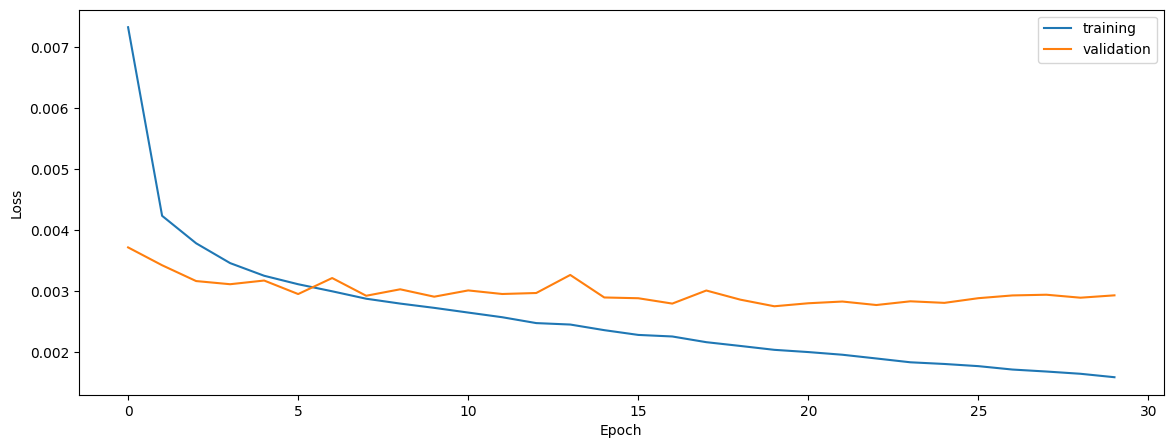

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8896039661725207
0.8355579277279636
0.8246707422345286


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8896039661725207
0.8355579277279636
0.8246707422345286


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.887938769428159
0.8307733922152756
0.8231996374065264


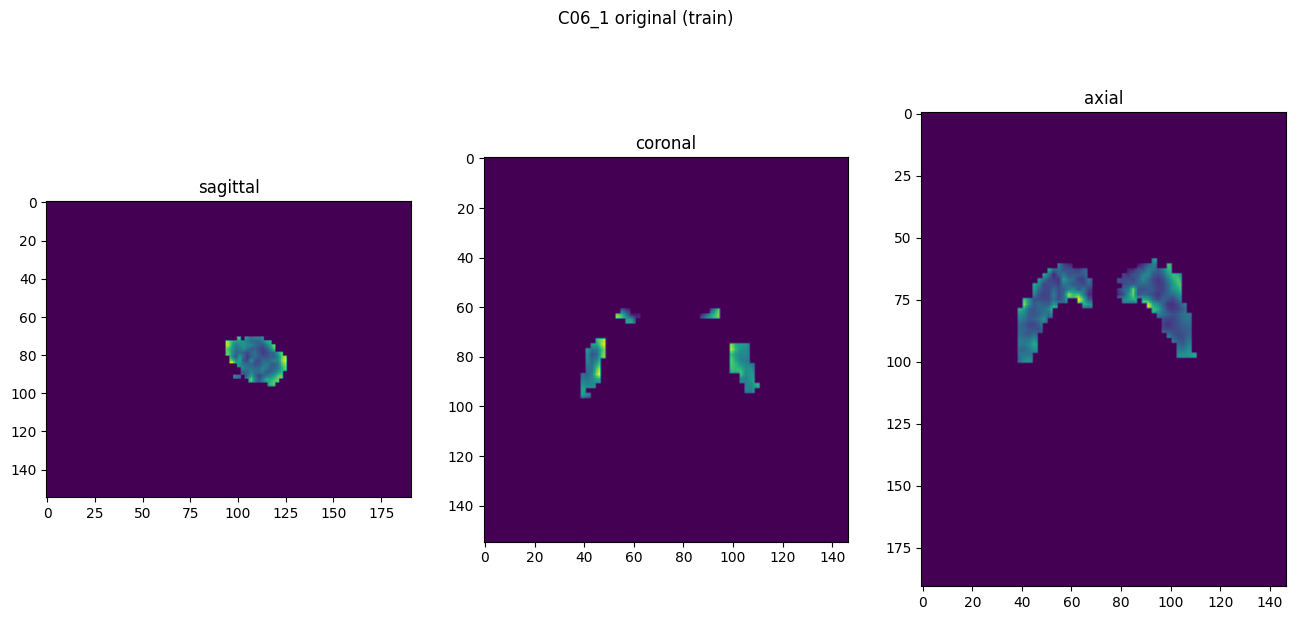

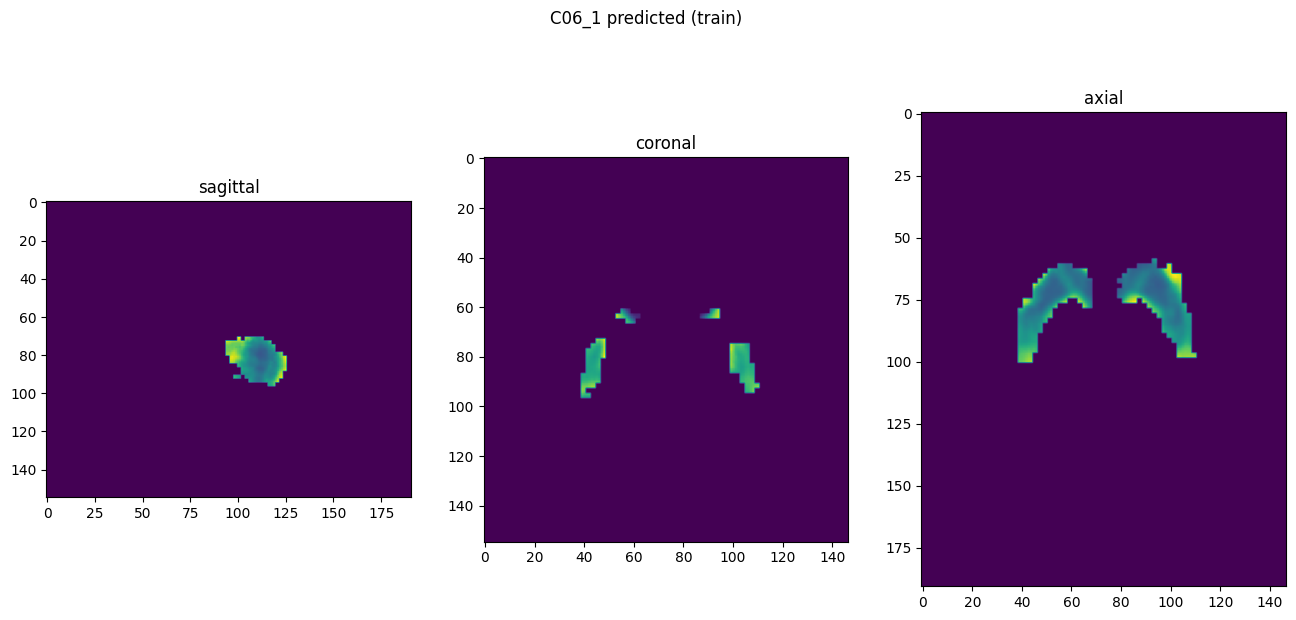

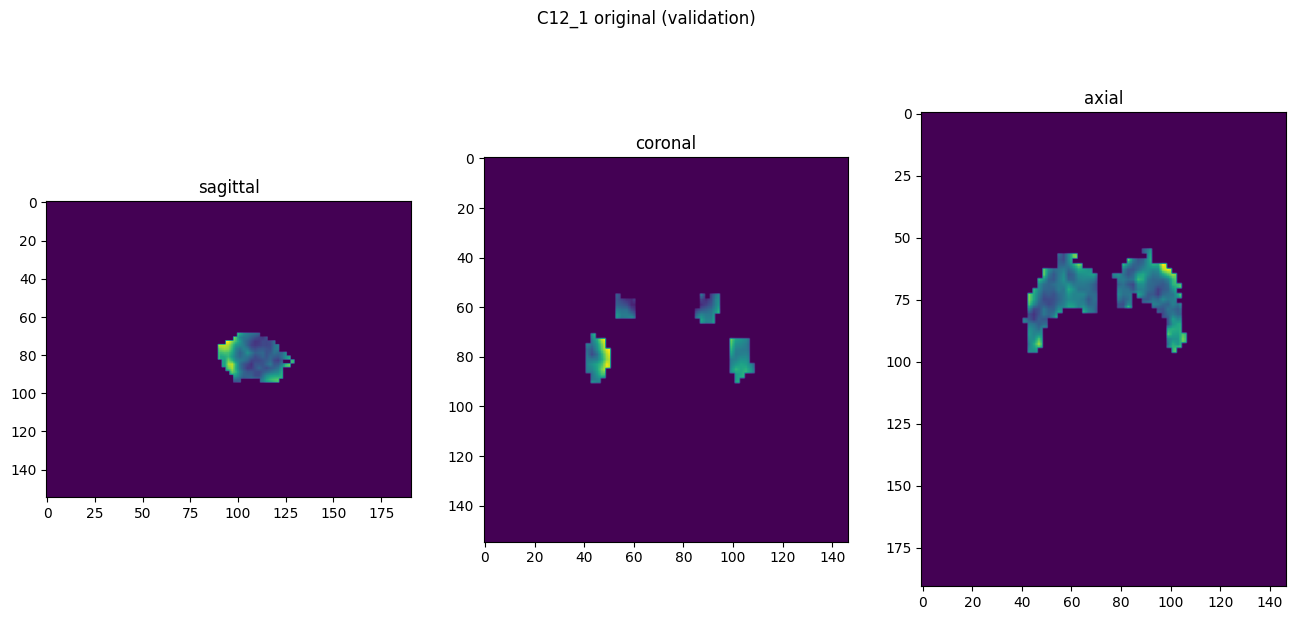

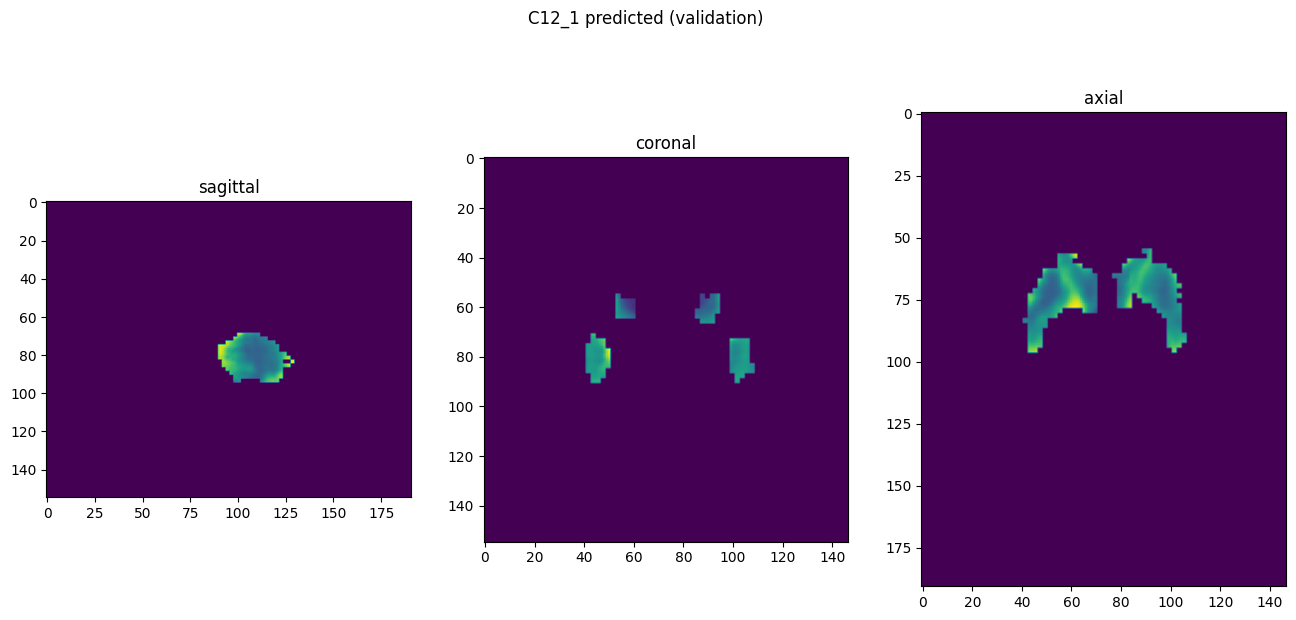

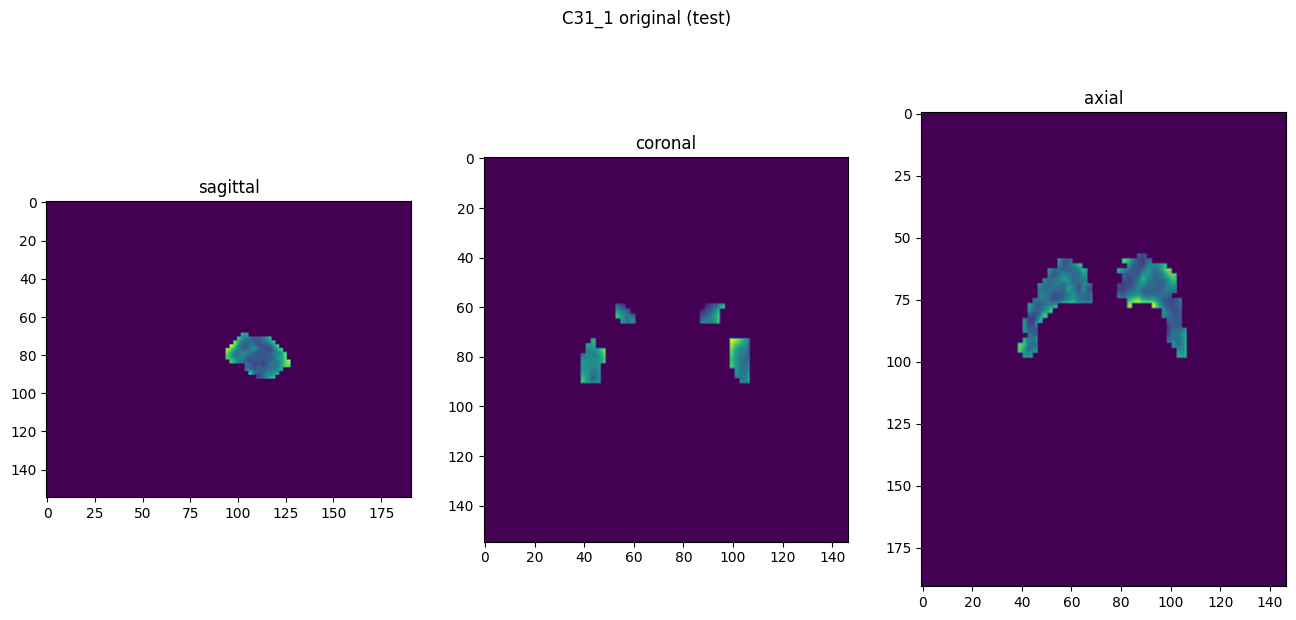

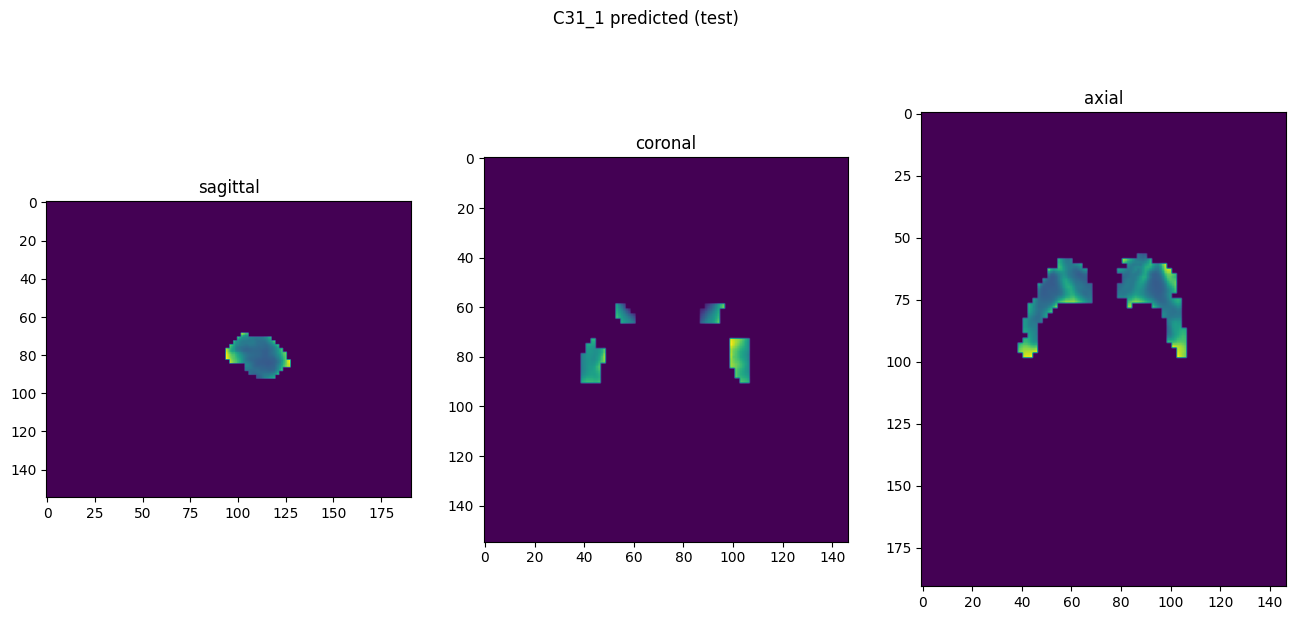

In [10]:
showResults(model, gen, threshold=None, background=False)